### Processing of both AUs and Compound Emotions

if we were to create a pipeline for both AUs and Compound Emotions, we would need to use this processing since some images are annotated with null values for the AU labels.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
working_dir = "../../../../Downloads/Vision-LLM-FER-CE-dev/Vision-LLM-FER-CE-dev/data/"
compound_df = pd.read_csv(working_dir+"compound_df_clean.csv")
au_df =  pd.read_csv(working_dir+"au_features_clean.csv")
print(au_df.shape)

(4549, 30)


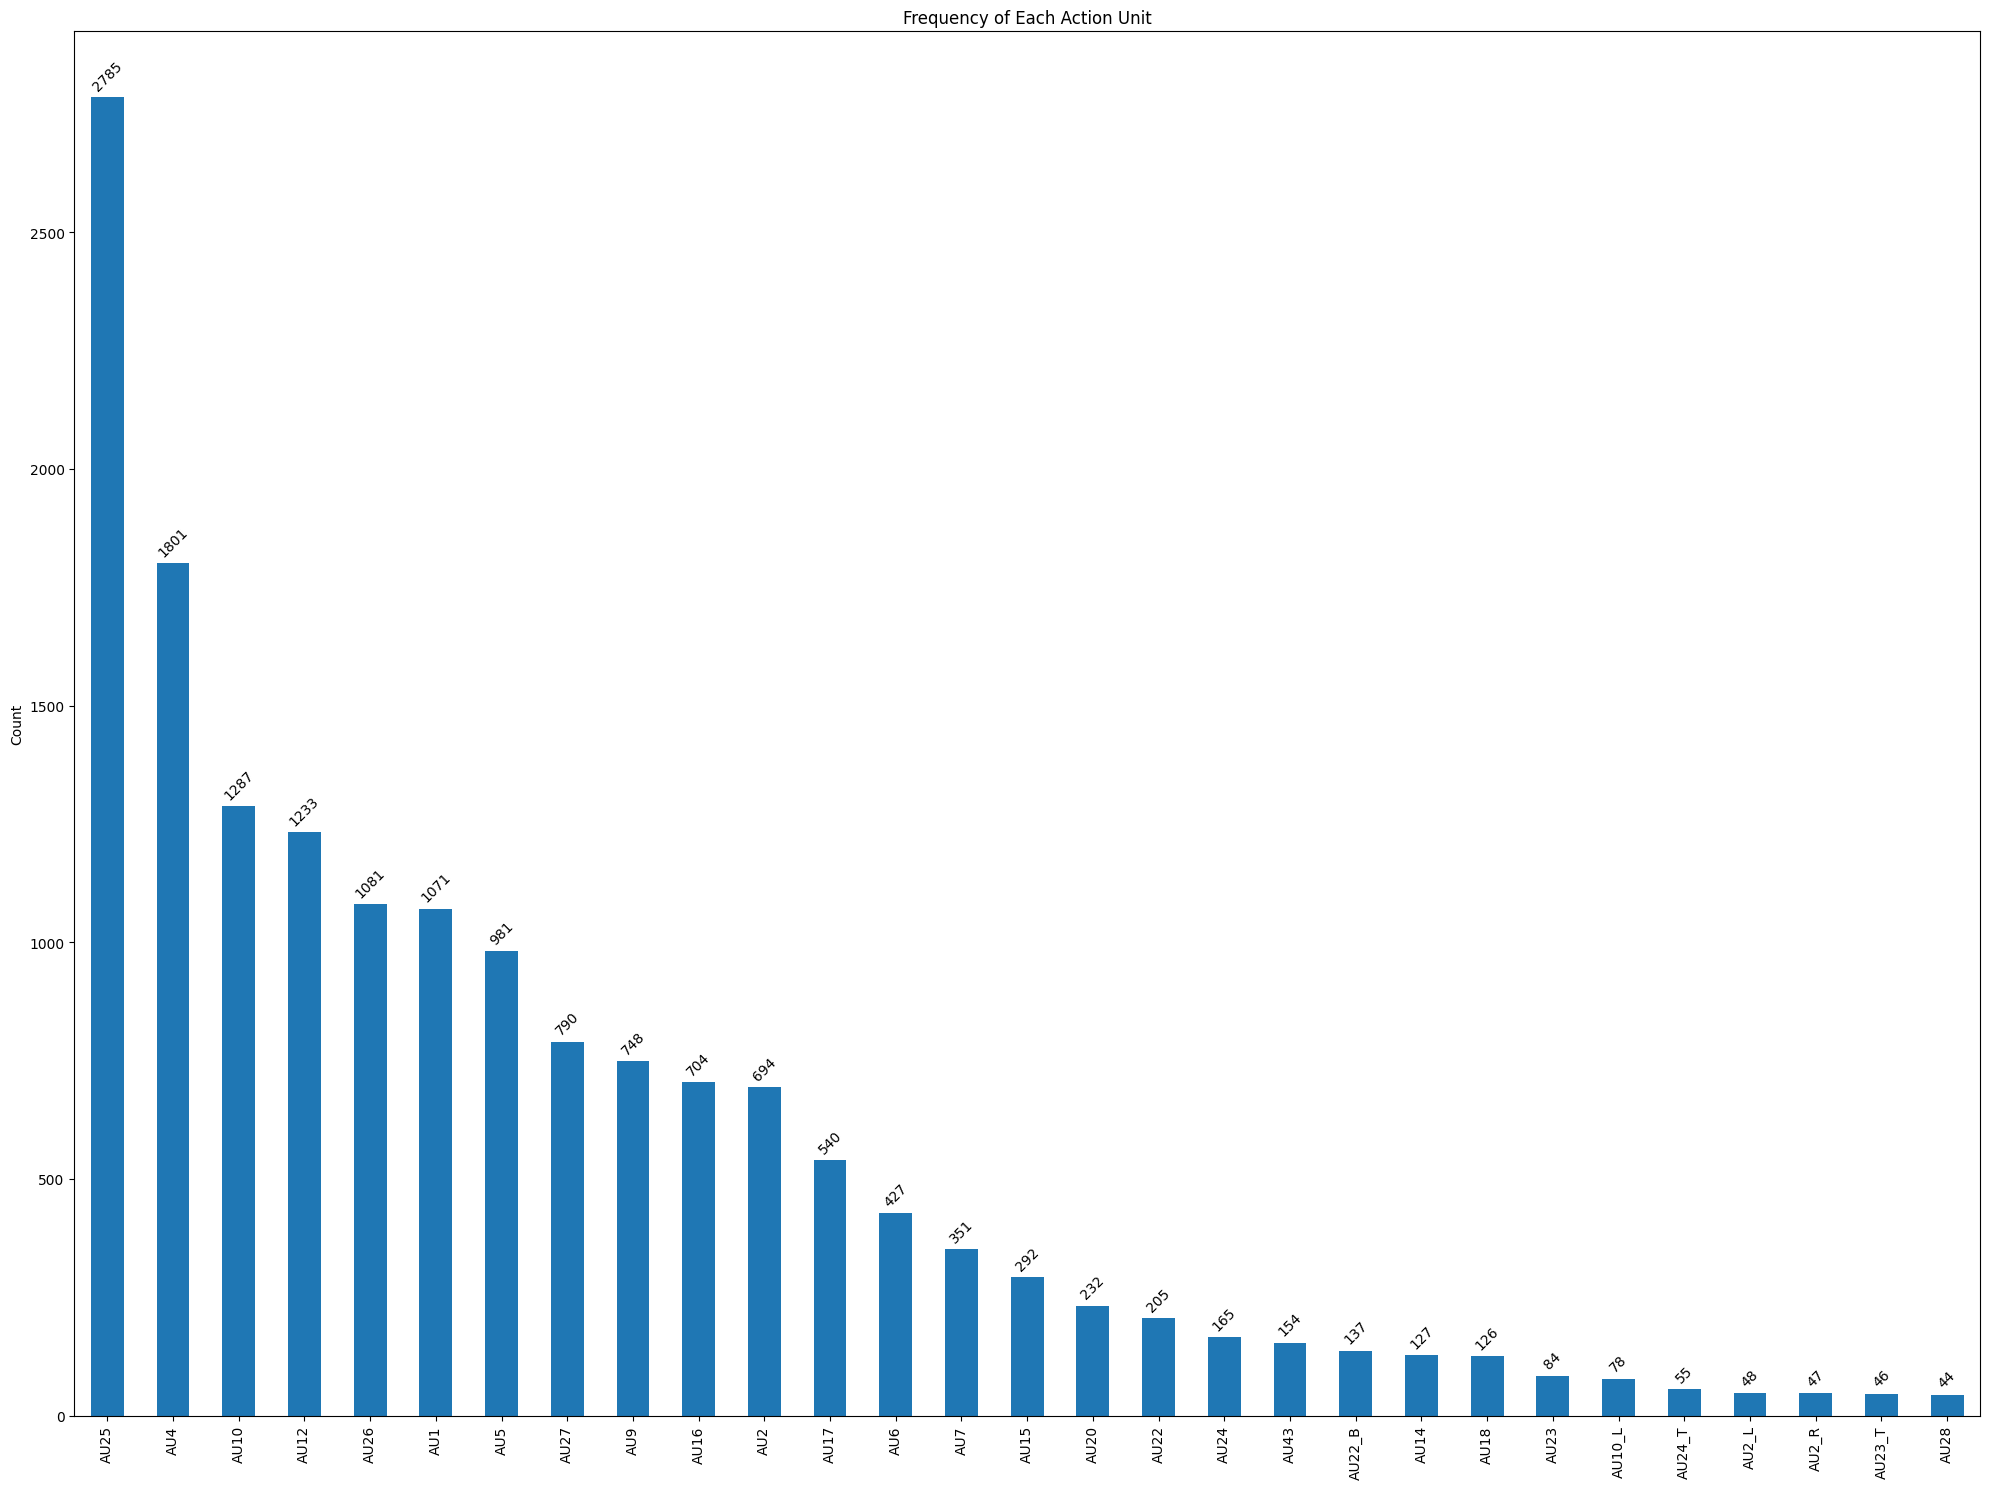

In [3]:
plt.figure(figsize=(20,15))
au_columns = [c for c in au_df.columns.drop("image")]
au_frequencies = au_df[au_columns].sum().sort_values(ascending=False)

ax = au_frequencies.plot(kind="bar")

ax.bar_label(ax.containers[0], padding=3, rotation=45)

plt.title("Frequency of Each Action Unit")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

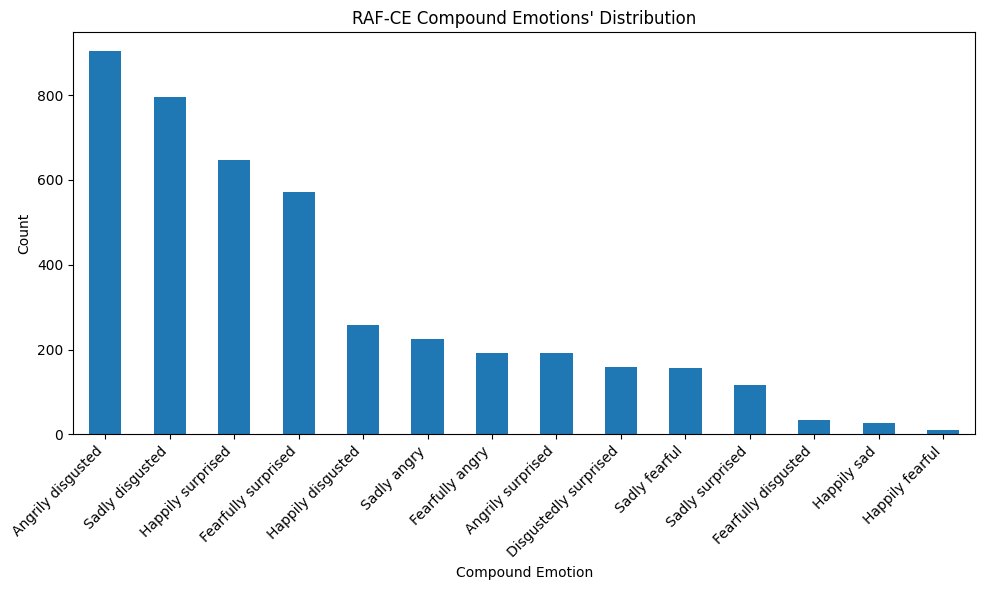

In [4]:

emotion_map = {
    0: 'Happily surprised',
    1: 'Happily disgusted',
    2: 'Sadly fearful',
    3: 'Sadly angry',
    4: 'Sadly surprised',
    5: 'Sadly disgusted',
    6: 'Fearfully angry',
    7: 'Fearfully surprised',
    8: 'Fearfully disgusted',
    9: 'Angrily surprised',
    10: 'Angrily disgusted',
    11: 'Disgustedly surprised',
    12: 'Happily fearful',
    13: 'Happily sad'
}
counts = compound_df["compound_emotion"].value_counts()
counts.index = counts.index.map(emotion_map)
counts.plot(kind="bar", figsize=(10,6))
plt.title("RAF-CE Compound Emotions' Distribution")
plt.xlabel("Compound Emotion")
plt.ylabel("Count")
plt.xticks(rotation=45,ha="right")
plt.tight_layout()
plt.show()

In [5]:
print(counts)

compound_emotion
Angrily disgusted        903
Sadly disgusted          795
Happily surprised        646
Fearfully surprised      572
Happily disgusted        259
Sadly angry              225
Fearfully angry          192
Angrily surprised        192
Disgustedly surprised    160
Sadly fearful            156
Sadly surprised          117
Fearfully disgusted       35
Happily sad               28
Happily fearful           11
Name: count, dtype: int64


Huge class imbalance 

### Processing of the compound emotions 
this section will be dedicated to the processing of the compound emotions only.

In [6]:
compound_emotion_labels = pd.read_csv(
    "../../../../Downloads/Vision-LLM-FER-CE-dev/Vision-LLM-FER-CE-dev/data/RAFCE_emolabel.txt",
    sep=r"\s+",
    header=None,
    names=["image","compound_emotion"]
)
compound_emotion_labels.head()

,image,compound_emotion
0,0001.jpg,5
1,0002.jpg,5
2,0003.jpg,10
3,0004.jpg,3
4,0005.jpg,10


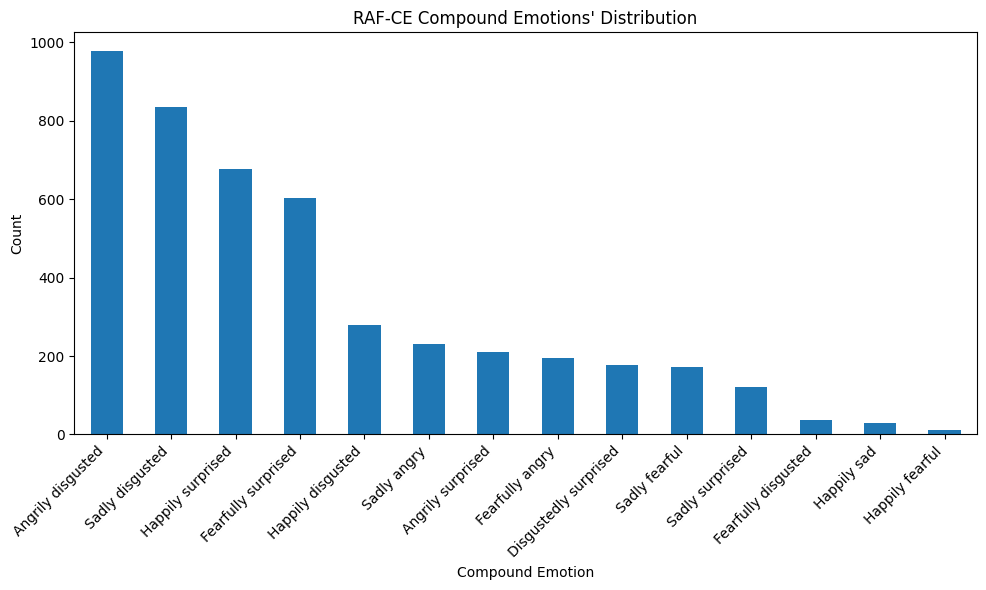

In [7]:

emotion_map = {
    0: 'Happily surprised',
    1: 'Happily disgusted',
    2: 'Sadly fearful',
    3: 'Sadly angry',
    4: 'Sadly surprised',
    5: 'Sadly disgusted',
    6: 'Fearfully angry',
    7: 'Fearfully surprised',
    8: 'Fearfully disgusted',
    9: 'Angrily surprised',
    10: 'Angrily disgusted',
    11: 'Disgustedly surprised',
    12: 'Happily fearful',
    13: 'Happily sad'
}
counts = compound_emotion_labels["compound_emotion"].value_counts()
counts.index = counts.index.map(emotion_map)
counts.plot(kind="bar", figsize=(10,6))
plt.title("RAF-CE Compound Emotions' Distribution")
plt.xlabel("Compound Emotion")
plt.ylabel("Count")
plt.xticks(rotation=45,ha="right")
plt.tight_layout()
plt.show()

In [8]:
print(counts)

compound_emotion
Angrily disgusted        977
Sadly disgusted          835
Happily surprised        676
Fearfully surprised      603
Happily disgusted        279
Sadly angry              230
Angrily surprised        210
Fearfully angry          195
Disgustedly surprised    177
Sadly fearful            171
Sadly surprised          120
Fearfully disgusted       36
Happily sad               29
Happily fearful           11
Name: count, dtype: int64


In [9]:
import shutil
import os

split_file = "../../../../Downloads/Vision-LLM-FER-CE-dev/Vision-LLM-FER-CE-dev/data/RAFCE_partition.txt"         
img_dir = "../../../../Downloads/Vision-LLM-FER-CE-dev/Vision-LLM-FER-CE-dev/data/aligned"            
train_dir = "../../../../Downloads/Vision-LLM-FER-CE-dev/Vision-LLM-FER-CE-dev/data/train_images"        

os.makedirs(train_dir, exist_ok=True)

with open(split_file, "r") as f:
    lines = f.readlines()

for line in lines:
    parts = line.strip().split()
    if len(parts) != 2:
        continue  
    img_name, split_label = parts
    if split_label == "0": 
        src_path = os.path.join(img_dir, img_name)
        dst_path = os.path.join(train_dir, img_name)
        if os.path.exists(src_path):
            shutil.copy(src_path, dst_path)

In [10]:
train_img_dir = "../../../../Downloads/Vision-LLM-FER-CE-dev/Vision-LLM-FER-CE-dev/data/train_images" 
train_images = set(os.listdir(train_img_dir))

train_df = compound_df[compound_df['image'].isin(train_images)].copy()

print(f"Nombre d'images de train : {len(train_df)}")
print(train_df.head())

Nombre d'images de train : 2539
      image  compound_emotion
0  0001.jpg                 5
3  0004.jpg                 3
4  0005.jpg                10
5  0006.jpg                 3
6  0007.jpg                 2


In [11]:
counts = train_df["compound_emotion"].value_counts()
counts.index = counts.index.map(emotion_map)
print(counts)

compound_emotion
Angrily disgusted        530
Sadly disgusted          467
Happily surprised        376
Fearfully surprised      334
Happily disgusted        159
Sadly angry              133
Fearfully angry          117
Angrily surprised        113
Sadly fearful            101
Disgustedly surprised     94
Sadly surprised           70
Fearfully disgusted       23
Happily sad               16
Happily fearful            6
Name: count, dtype: int64


In [12]:
from torchvision import transforms

ultra_rare_augmentation = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(224, scale=(0.9, 1.1)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  
])

rare_augmentation = transforms.Compose([
    transforms.Resize((224,224)), 
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(5),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  
])

frequent_augmentation = transforms.Compose([
    transforms.Resize((224,224)), 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

In [13]:
from torch.utils.data import Dataset
from PIL import Image

class RAFCEDataset(Dataset):
    def __init__(self, df, img_dir):
        self.df = df
        self.img_dir = img_dir

        self.class_counts = df["compound_emotion"].value_counts()

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.img_dir, row["image"])
        image = Image.open(img_path).convert("RGB")
        label = row["compound_emotion"]

        count = self.class_counts[label]
        if count < 30:
            transform = ultra_rare_augmentation
        elif count < 200:
            transform = rare_augmentation
        else :
            transform = frequent_augmentation

        if transform:
            image = transform(image)
        
        return image, label

In [14]:
train_dataset = RAFCEDataset(df=train_df, img_dir="../../../../Downloads/Vision-LLM-FER-CE-dev/Vision-LLM-FER-CE-dev/data/train_images")

In [15]:
from torch.utils.data import DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [16]:
images, labels = next(iter(train_loader))
print(images.shape) 
print(labels[:10])

torch.Size([32, 3, 224, 224])
tensor([ 0, 10,  7,  0,  1,  5, 10,  5,  5,  4])


In [17]:
import torch
import torch.nn as nn
from torchvision.models import vit_b_16

device = "cuda" if torch.cuda.is_available() else "cpu"

model = vit_b_16(pretrained=True)

# Remplacer la tête de classification
model.heads.head = nn.Linear(model.heads.head.in_features, 14)

model = model.to(device)


c:\Users\hadil\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\hadil\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [18]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)


In [ ]:
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {running_loss/len(train_loader):.4f}")


In [ ]:
from sklearn.metrics import accuracy_score, f1_score
import numpy as np

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in train_loader:  # plus tard → val_loader
        images = images.to(device)
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

acc = accuracy_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds, average="macro")

print("Accuracy :", acc)
print("F1 macro :", f1)


Accuracy : 0.31508467900748327
F1 macro : 0.15682576690947667


In [ ]:
from torch.utils.data import random_split, DataLoader

# Supposons que train_dataset soit ton RAFCEDataset
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size

train_ds, val_ds = random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=64, shuffle=False)


In [ ]:
import torch.optim as optim

optimizer = optim.AdamW(model.parameters(), lr=3e-5)  # lr petit pour ViT


In [ ]:
from torch.optim.lr_scheduler import StepLR

scheduler = StepLR(optimizer, step_size=5, gamma=0.7)


In [1]:
pip install transformers accelerate pillow torch torchvision


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
!pip install einops transformers_stream_generator tiktoken hf_xet


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: C:\Python312\python.exe -m pip install --upgrade pip


In [3]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
from PIL import Image


c:\Users\hadil\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
!pip install tiktoken


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: C:\Python312\python.exe -m pip install --upgrade pip


In [7]:
import sys
!{sys.executable} -m pip install einops transformers_stream_generator tiktoken hf_xet


  Using cached einops-0.8.1-py3-none-any.whl.metadata (13 kB)
  Using cached transformers-stream-generator-0.0.5.tar.gz (13 kB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Using cached hf_xet-1.2.0-cp37-abi3-win_amd64.whl.metadata (5.0 kB)
Using cached einops-0.8.1-py3-none-any.whl (64 kB)
Using cached hf_xet-1.2.0-cp37-abi3-win_amd64.whl (2.9 MB)
  Created wheel for transformers_stream_generator: filename=transformers_stream_generator-0.0.5-py3-none-any.whl size=12549 sha256=88cd2b867a73fbe4b3186d6a5b2230b5bc17849afd91cf4cc42250eb14556f74
  Stored in directory: c:\users\hadil\appdata\local\pip\cache\wheels\f6\6e\1a\710143d0e50e827ae5b60a47a6d43d715cf1c6e35881a05530
Successfully built transformers_strea


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import sys
!{sys.executable} -m pip install transformers==4.36.2 --force-reinstall


  Using cached filelock-3.20.3-py3-none-any.whl.metadata (2.1 kB)
  Using cached huggingface_hub-0.36.0-py3-none-any.whl.metadata (14 kB)
  Using cached numpy-2.4.1-cp313-cp313-win_amd64.whl.metadata (6.6 kB)
  Using cached packaging-25.0-py3-none-any.whl.metadata (3.3 kB)
  Using cached pyyaml-6.0.3-cp313-cp313-win_amd64.whl.metadata (2.4 kB)
  Using cached regex-2026.1.15-cp313-cp313-win_amd64.whl.metadata (41 kB)
  Using cached requests-2.32.5-py3-none-any.whl.metadata (4.9 kB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Installing backend dependencies: started
  Installing backend dependencies: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): still running...
  Preparing metadata (pyproject.toml): finished with status 'error'


  error: subprocess-exited-with-error
  
  × Preparing metadata (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [80 lines of output]
      Checking for Rust toolchain....
      Rust not found, installing into a temporary directory
      Python reports SOABI: cp313-win_amd64
      Computed rustc target triple: x86_64-pc-windows-msvc
      Installation directory: C:\Users\hadil\AppData\Local\puccinialin\puccinialin\Cache
      
      Installing rust to C:\Users\hadil\AppData\Local\puccinialin\puccinialin\Cache\rustup
      info: profile set to 'minimal'
      info: default host triple is x86_64-pc-windows-msvc
      info: syncing channel updates for 'stable-x86_64-pc-windows-msvc'
      info: latest update on 2025-12-11, rust version 1.92.0 (ded5c06cf 2025-12-08)
      info: downloading component 'cargo'
      info: downloading component 'rust-std'
      info: downloading component 'rustc'
      info: installing component 'cargo'
      info: installing component 'rust-s

In [ ]:
import torch
import transformers
import einops
import transformers_stream_generator
print("Dependencies OK ✅")


c:\Users\hadil\Downloads\Vision-LLM-FER-CE-dev\venv_qwen310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ImportError: cannot import name 'BeamSearchScorer' from 'transformers' (c:\Users\hadil\Downloads\Vision-LLM-FER-CE-dev\venv_qwen310\lib\site-packages\transformers\__init__.py)

In [1]:
import einops
import transformers_stream_generator
print("Dependencies OK ✅")


c:\Users\hadil\Downloads\Vision-LLM-FER-CE-dev\venv_qwen310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Dependencies OK ✅


In [16]:
pip install huggingface_hub[hf_xet]


Note: you may need to restart the kernel to use updated packages.


In [106]:
# =============================================================================
# 🎯 COMPLETE FER-CE PIPELINE (CLIP + CLASSIFIER)
# =============================================================================

import os
import pandas as pd
import torch
import torch.nn as nn
from PIL import Image
from transformers import CLIPProcessor, CLIPVisionModel
import warnings
warnings.filterwarnings('ignore')

# -------------------------------------------------------------------------
# 🔧 CONFIG (ADAPTE À TON DATASET)
# -------------------------------------------------------------------------
BASE_DIR = "../../../../Downloads/Vision-LLM-FER-CE-dev/Vision-LLM-FER-CE-dev/data"
CSV_FILE = os.path.join(BASE_DIR, "fer_ce_train.csv")
PROCESSED_IMAGES = os.path.join(BASE_DIR, "train_images")  # dossier avec images
OUTPUT_DIR = os.path.join(BASE_DIR, "output_clip_classifier")
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Mapping des émotions composées (RAF-CE)
EMOTION_TEMPLATES = {
    0: 'Happily surprised', 1: 'Happily disgusted', 2: 'Sadly fearful', 3: 'Sadly angry',
    4: 'Sadly surprised', 5: 'Sadly disgusted', 6: 'Fearfully angry', 7: 'Fearfully surprised',
    8: 'Fearfully disgusted', 9: 'Angrily surprised', 10: 'Angrily disgusted', 11: 'Disgustedly surprised',
    12: 'Happily fearful', 13: 'Happily sad'
}

# -------------------------------------------------------------------------
# 🔹 LOAD DATASET
# -------------------------------------------------------------------------
df = pd.read_csv(CSV_FILE)

# Créer colonnes nécessaires pour le pipeline
df['label'] = df['compound_emotion']  # label pour le classifier
df['image_path_processed'] = df['image']  # chemin relatif pour les images

print(f"📊 Dataset loaded: {len(df)} images")

# Utiliser seulement les 500 premières images pour un test rapide
dataset_data = []
for idx, row in df.iterrows():
    sample = {
        "id": f"fer_ce_{idx:04d}",
        "image": row['image_path_processed'],
        "label": int(row['label']),
        "emotion_name": EMOTION_TEMPLATES[row['label']]
    }
    dataset_data.append(sample)

print(f"✅ Dataset ready: {len(dataset_data)} samples")

# -------------------------------------------------------------------------
# 🔹 LOAD CLIP VISION
# -------------------------------------------------------------------------
print("🔄 Loading CLIP Vision...")
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
clip_vision = CLIPVisionModel.from_pretrained("openai/clip-vit-base-patch32")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
clip_vision.to(device)
# =============================
# 🔓 PARTIAL FINE-TUNING CLIP
# =============================

# Geler tout CLIP
for param in clip_vision.parameters():
    param.requires_grad = False

for name, param in clip_vision.named_parameters():
    if "encoder.layers.8" in name or "encoder.layers.9" in name or "encoder.layers.10" in name or "encoder.layers.11" in name:
        param.requires_grad = True




# -------------------------------------------------------------------------
# 🔹 CLASSIFIER (LINEAR)
# -------------------------------------------------------------------------
classifier = nn.Sequential(
    nn.Linear(768, 512),
    nn.ReLU(),
    nn.BatchNorm1d(512),
    nn.Dropout(0.4),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(256, 14)
).to(device)
  # 768 = hidden size CLIP
classifier.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW([
    {"params": classifier.parameters(), "lr": 1e-3},
    {"params": filter(lambda p: p.requires_grad, clip_vision.parameters()), "lr": 1e-5}
])


# -------------------------------------------------------------------------
# 🔹 TRAINING LOOP (QUICK TRAIN)
# -------------------------------------------------------------------------
print("🚀 QUICK TRAINING...")
batch_size = 16
num_epochs = 10
clip_vision.train()
classifier.train()

for epoch in range(num_epochs):
    total_loss = 0
    for i in range(0, len(dataset_data), batch_size):
        batch = dataset_data[i:i+batch_size]
        images, labels = [], []
        
        # Charger les images
        for sample in batch:
            img_path = os.path.join(PROCESSED_IMAGES, sample['image'])
            if os.path.exists(img_path):
                image = Image.open(img_path).convert('RGB').resize((224, 224))
                images.append(image)
                labels.append(sample['label'])
        
        if len(images) == 0:
            continue

        # Features CLIP
        inputs = clip_processor(images=images, return_tensors="pt").to(device)
        
        features = clip_vision(**inputs).last_hidden_state[:, 0]
         # CLS token
        
        # Classifier forward + backward
        logits = classifier(features)
        labels_tensor = torch.tensor(labels[:len(images)], dtype=torch.long).to(device)
        loss = criterion(logits, labels_tensor)


        optimizer.zero_grad()
        loss.backward()

        optimizer.step()

        total_loss += loss.item()
    
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss:.3f}")

# -------------------------------------------------------------------------
# 🔹 SAVE MODEL
# -------------------------------------------------------------------------
model_path = os.path.join(OUTPUT_DIR, "fer_ce_classifier.pth")
torch.save(classifier.state_dict(), model_path)
print(f"✅ Classifier saved to {model_path}")


📊 Dataset loaded: 3432 images
✅ Dataset ready: 3432 samples
🔄 Loading CLIP Vision...


Some weights of the model checkpoint at openai/clip-vit-base-patch32 were not used when initializing CLIPVisionModel: ['text_model.encoder.layers.11.self_attn.q_proj.weight', 'text_model.encoder.layers.7.layer_norm2.bias', 'text_model.encoder.layers.10.self_attn.out_proj.bias', 'text_model.encoder.layers.11.layer_norm2.weight', 'text_model.encoder.layers.2.layer_norm1.weight', 'text_model.encoder.layers.10.mlp.fc2.bias', 'text_model.encoder.layers.4.self_attn.out_proj.weight', 'text_model.encoder.layers.0.mlp.fc2.weight', 'logit_scale', 'text_model.encoder.layers.3.self_attn.q_proj.bias', 'text_model.encoder.layers.0.self_attn.out_proj.weight', 'text_model.encoder.layers.9.layer_norm2.weight', 'text_model.encoder.layers.4.layer_norm2.bias', 'text_model.encoder.layers.4.self_attn.k_proj.bias', 'text_model.encoder.layers.9.mlp.fc1.bias', 'text_model.encoder.layers.1.self_attn.q_proj.weight', 'text_model.encoder.layers.7.mlp.fc2.weight', 'text_model.final_layer_norm.weight', 'text_model.e

🚀 QUICK TRAINING...
Epoch 1/10, Loss: 385.629
Epoch 2/10, Loss: 279.739
Epoch 3/10, Loss: 207.361
Epoch 4/10, Loss: 151.807
Epoch 5/10, Loss: 94.643
Epoch 6/10, Loss: 81.143
Epoch 7/10, Loss: 59.781
Epoch 8/10, Loss: 47.962
Epoch 9/10, Loss: 34.035
Epoch 10/10, Loss: 28.967
✅ Classifier saved to ../../../../Downloads/Vision-LLM-FER-CE-dev/Vision-LLM-FER-CE-dev/data\output_clip_classifier\fer_ce_classifier.pth


In [107]:
import pandas as pd

# 📂 Chemin de ton CSV complet
compound_csv = "../../../../Downloads/Vision-LLM-FER-CE-dev/Vision-LLM-FER-CE-dev/data/compound_df_clean.csv"

# 🔹 Lire le CSV
df = pd.read_csv(compound_csv)
print(f"Nombre total d'images : {len(df)}")

# 🔹 Split train / val / test
train_df = df.sample(frac=0.7, random_state=42)  # 70% pour l'entraînement
temp_df = df.drop(train_df.index)
val_df = temp_df.sample(frac=0.5, random_state=42)  # 15% pour validation
test_df = temp_df.drop(val_df.index)                # 15% pour test

print(f"Train : {len(train_df)}, Val : {len(val_df)}, Test : {len(test_df)}")

# 🔹 Sauvegarder les CSV
val_csv_path = "../../../../Downloads/Vision-LLM-FER-CE-dev/Vision-LLM-FER-CE-dev/data/fer_ce_val.csv"
test_csv_path = "../../../../Downloads/Vision-LLM-FER-CE-dev/Vision-LLM-FER-CE-dev/data/fer_ce_test.csv"

val_df.to_csv(val_csv_path, index=False)
test_df.to_csv(test_csv_path, index=False)

print("✅ CSV de validation et test créés !")
print(f"Validation CSV : {val_csv_path}")
print(f"Test CSV       : {test_csv_path}")


Nombre total d'images : 4291
Train : 3004, Val : 644, Test : 643
✅ CSV de validation et test créés !
Validation CSV : ../../../../Downloads/Vision-LLM-FER-CE-dev/Vision-LLM-FER-CE-dev/data/fer_ce_val.csv
Test CSV       : ../../../../Downloads/Vision-LLM-FER-CE-dev/Vision-LLM-FER-CE-dev/data/fer_ce_test.csv


In [108]:
from pathlib import Path
from PIL import Image
import os
import pandas as pd

# =========================
# PATHS VALIDATION / TEST
# =========================
VAL_CSV = "../../../../Downloads/Vision-LLM-FER-CE-dev/Vision-LLM-FER-CE-dev/data/fer_ce_val.csv"
TEST_CSV = "../../../../Downloads/Vision-LLM-FER-CE-dev/Vision-LLM-FER-CE-dev/data/fer_ce_test.csv"
IMG_DIR = "../../../../Downloads/Vision-LLM-FER-CE-dev/Vision-LLM-FER-CE-dev/data/aligned"

# =========================
# Fonction pour charger et prétraiter
# =========================
def load_and_preprocess_csv(csv_path, image_base_dir, max_samples=500):
    """
    Charge un CSV de validation/test et crée un dataset
    avec le même prétraitement que le training.
    """
    df = pd.read_csv(csv_path)
    dataset_data = []

    for idx, row in df.head(max_samples).iterrows():
        # Chemin complet de l'image
        img_path = os.path.join(image_base_dir, row['image'])
        
        try:
            # Prétraitement similaire au training
            image = Image.open(img_path).convert('RGB').resize((224, 224))
            sample = {
                "id": f"{Path(csv_path).stem}_{idx:04d}",
                "image": image,                     # PIL Image
                "label": int(row['compound_emotion']),  # Label 0-13
                "emotion_name": EMOTION_TEMPLATES[int(row['compound_emotion'])]
            }
            dataset_data.append(sample)
        except Exception as e:
            print(f"⚠️ Skip {img_path}: {e}")
            continue

    print(f"✅ Loaded {len(dataset_data)} samples from {Path(csv_path).name}")
    return dataset_data

# =========================
# Charger validation + test (limité à 500 images pour tester)
# =========================
val_data = load_and_preprocess_csv(VAL_CSV, IMG_DIR, max_samples=500)
test_data = load_and_preprocess_csv(TEST_CSV, IMG_DIR, max_samples=500)


✅ Loaded 500 samples from fer_ce_val.csv
✅ Loaded 500 samples from fer_ce_test.csv


In [109]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Charger le CSV complet
compound_df = pd.read_csv("../../../../Downloads/Vision-LLM-FER-CE-dev/Vision-LLM-FER-CE-dev/data/compound_df_clean.csv")

# Séparer 80% train, 10% val, 10% test
train_df, temp_df = train_test_split(compound_df, test_size=0.2, random_state=42, stratify=compound_df['compound_emotion'])
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df['compound_emotion'])

# Sauvegarder les CSV
train_df.to_csv("../../../../Downloads/Vision-LLM-FER-CE-dev/Vision-LLM-FER-CE-dev/data/fer_ce_train.csv", index=False)
val_df.to_csv("../../../../Downloads/Vision-LLM-FER-CE-dev/Vision-LLM-FER-CE-dev/data/fer_ce_val.csv", index=False)
test_df.to_csv("../../../../Downloads/Vision-LLM-FER-CE-dev/Vision-LLM-FER-CE-dev/data/fer_ce_test.csv", index=False)

print("✅ CSV train/val/test créés !")


✅ CSV train/val/test créés !


In [110]:
from PIL import Image
import os
from pathlib import Path

# 🔹 Définir le nombre maximum d’images à charger
MAX_SAMPLES = 500  # tu peux ajuster pour tester plus vite

# 🔹 Chemins
Processed_images = "../../../../Downloads/Vision-LLM-FER-CE-dev/Vision-LLM-FER-CE-dev/data/aligned"  # dossier des images originales ou traitées
VAL_CSV = "../../../../Downloads/Vision-LLM-FER-CE-dev/Vision-LLM-FER-CE-dev/data/fer_ce_val.csv"
TEST_CSV = "../../../../Downloads/Vision-LLM-FER-CE-dev/Vision-LLM-FER-CE-dev/data/fer_ce_test.csv"

# 🔹 Fonction de chargement et prétraitement
def load_and_preprocess_csv(csv_path, image_base_dir, max_samples=500):
    df = pd.read_csv(csv_path)
    dataset_data = []

    for idx, row in df.head(max_samples).iterrows():
        # Construire le chemin complet de l'image
        img_path = os.path.join(image_base_dir, row['image'])
        try:
            # Charger l'image et redimensionner
            image = Image.open(img_path).convert('RGB').resize((224, 224))
            sample = {
                "id": f"{Path(csv_path).stem}_{idx:04d}",
                "image": image,
                "label": int(row['compound_emotion']),  # colonne dans ton CSV
                "emotion_name": row['compound_emotion']  # ou mapper si tu veux les noms
            }
            dataset_data.append(sample)
        except Exception as e:
            print(f"⚠️ Skip {img_path}: {e}")
            continue

    print(f"✅ Loaded {len(dataset_data)} samples from {csv_path}")
    return dataset_data

# 🔹 Charger validation et test
val_data = load_and_preprocess_csv(VAL_CSV, Processed_images, max_samples=MAX_SAMPLES)
test_data = load_and_preprocess_csv(TEST_CSV, Processed_images, max_samples=MAX_SAMPLES)

print(f"✅ Validation data loaded: {len(val_data)} images")
print(f"✅ Test data loaded: {len(test_data)} images")


✅ Loaded 429 samples from ../../../../Downloads/Vision-LLM-FER-CE-dev/Vision-LLM-FER-CE-dev/data/fer_ce_val.csv
✅ Loaded 430 samples from ../../../../Downloads/Vision-LLM-FER-CE-dev/Vision-LLM-FER-CE-dev/data/fer_ce_test.csv
✅ Validation data loaded: 429 images
✅ Test data loaded: 430 images


In [111]:
# 🔹 Évaluation rapide du modèle (avec PIL images préchargées)
@torch.no_grad()
def evaluate_model_fast(data, batch_size=16, name=""):
    all_preds, all_labels = [], []

    for i in range(0, len(data), batch_size):
        batch = data[i:i+batch_size]
        images = [sample['image'] for sample in batch]  # PIL images déjà chargées
        labels = [sample['label'] for sample in batch]

        # Transformer en tenseur CLIP
        inputs = clip_processor(images=images, return_tensors="pt").to(device)

        # Extraire les features avec CLIP Vision
        features = clip_vision(**inputs).last_hidden_state[:, 0]  # CLS token

        # Classifier
        logits = classifier(features)
        preds = torch.argmax(logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels)

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    print(f"✅ {name} evaluation done: {len(all_preds)} samples processed")
    return all_preds, all_labels


In [112]:
import numpy as np
from sklearn.metrics import accuracy_score, f1_score

# 🔹 Évaluer sur Validation Set
print("🔍 Evaluating Validation Set...")
val_preds, val_labels = evaluate_model_fast(val_data, batch_size=16, name="Validation")
val_acc = accuracy_score(val_labels, val_preds)
val_f1  = f1_score(val_labels, val_preds, average="macro")
print(f"✅ Validation Accuracy: {val_acc:.4f}, F1 macro: {val_f1:.4f}")

# 🔹 Évaluer sur Test Set
print("🔍 Evaluating Test Set...")
test_preds, test_labels = evaluate_model_fast(test_data, batch_size=16, name="Test")
test_acc = accuracy_score(test_labels, test_preds)
test_f1  = f1_score(test_labels, test_preds, average="macro")
print(f"✅ Test Accuracy: {test_acc:.4f}, F1 macro: {test_f1:.4f}")


🔍 Evaluating Validation Set...
✅ Validation evaluation done: 429 samples processed
✅ Validation Accuracy: 0.4755, F1 macro: 0.2815
🔍 Evaluating Test Set...
✅ Test evaluation done: 430 samples processed
✅ Test Accuracy: 0.5186, F1 macro: 0.3166


In [113]:
print(f"\n🎯 FINAL RESULTS:")
print(f"✅ Validation Accuracy: {val_acc:.3f}")
print(f"✅ Test Accuracy:     {test_acc:.3f}")



🎯 FINAL RESULTS:
✅ Validation Accuracy: 0.476
✅ Test Accuracy:     0.519



📊 VALIDATION RESULTS
                       precision    recall  f1-score   support

    Happily Surprised      0.623     0.594     0.608        64
    Happily Disgusted      0.409     0.346     0.375        26
        Sadly Fearful      0.333     0.250     0.286        16
          Sadly Angry      0.115     0.136     0.125        22
      Sadly Surprised      0.167     0.167     0.167        12
      Sadly Disgusted      0.638     0.557     0.595        79
      Fearfully Angry      0.444     0.600     0.511        20
  Fearfully Surprised      0.492     0.544     0.517        57
  Fearfully Disgusted      0.000     0.000     0.000         4
    Angrily Surprised      0.091     0.053     0.067        19
    Angrily Disgusted      0.584     0.656     0.618        90
Disgustedly Surprised      0.091     0.062     0.074        16
      Happily Fearful      0.000     0.000     0.000         1
          Happily Sad      0.000     0.000     0.000         3

             accuracy          

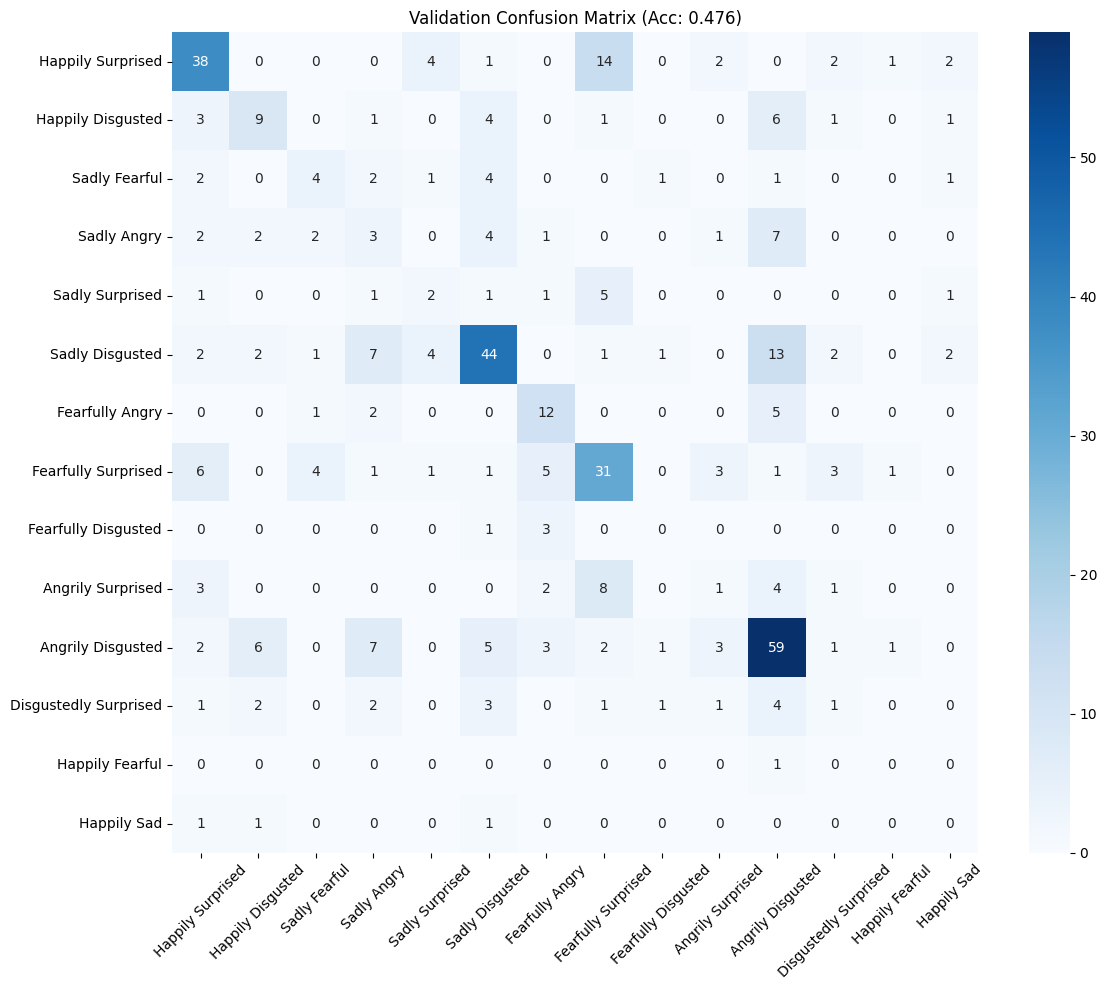

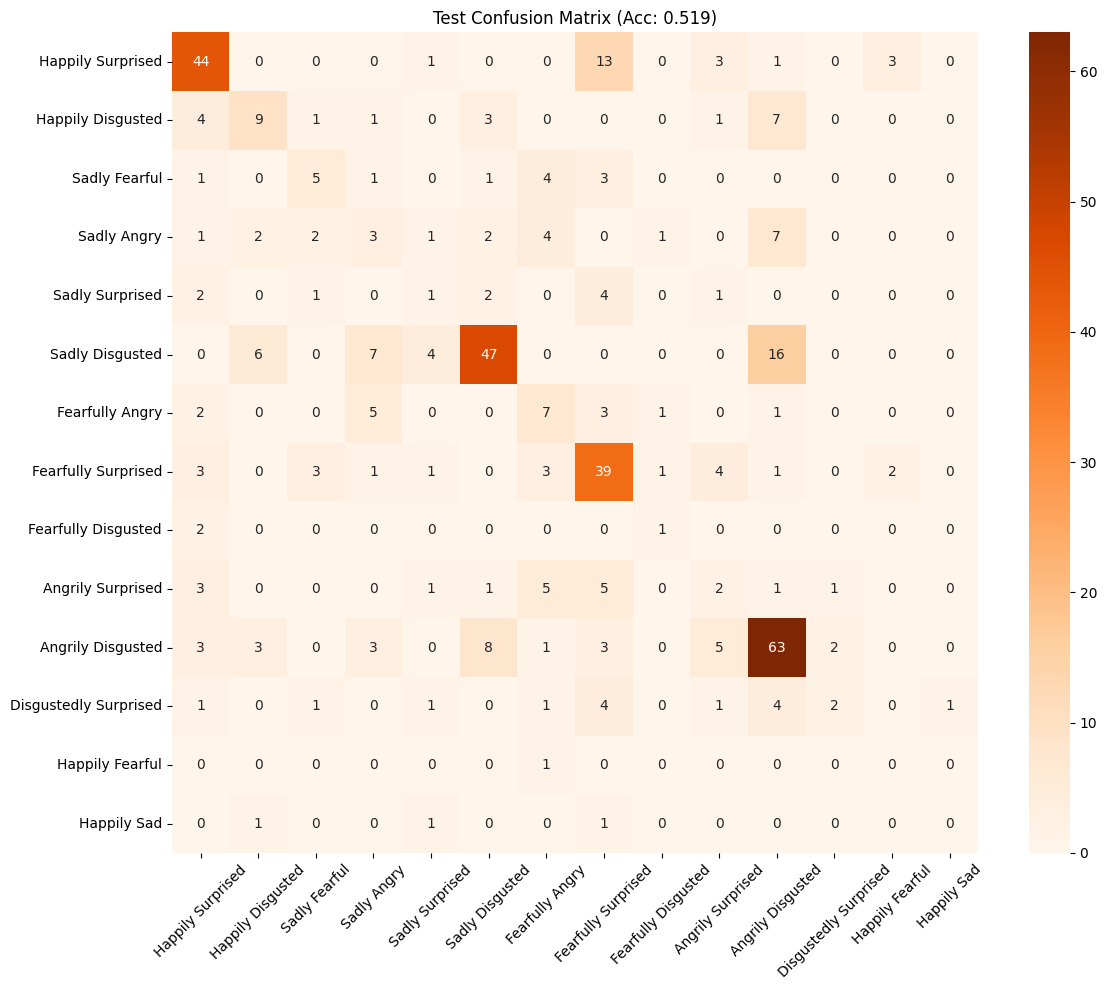


📋 SUMMARY
          Validation   Test
Accuracy       0.476  0.519
Macro-F1       0.281  0.317


In [114]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 14-class emotion names (correspondant à ton dataset)
emotion_names = [
    "Happily Surprised", "Happily Disgusted", "Sadly Fearful",
    "Sadly Angry", "Sadly Surprised", "Sadly Disgusted",
    "Fearfully Angry", "Fearfully Surprised", "Fearfully Disgusted",
    "Angrily Surprised", "Angrily Disgusted", "Disgustedly Surprised",
    "Happily Fearful", "Happily Sad"
]

# ===== VALIDATION RESULTS =====
print("\n📊 VALIDATION RESULTS")
print("="*70)
print(classification_report(val_labels, val_preds, 
                            target_names=emotion_names, digits=3))
print(f"Accuracy: {val_acc:.3f}\n")

# ===== TEST RESULTS =====
print("📊 TEST RESULTS") 
print("="*70)
print(classification_report(test_labels, test_preds, 
                            target_names=emotion_names, digits=3))
print(f"Accuracy: {test_acc:.3f}")

# ===== CONFUSION MATRICES (Seaborn) =====
plt.figure(figsize=(12, 10))
cm_val = confusion_matrix(val_labels, val_preds)
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues',
            xticklabels=emotion_names, yticklabels=emotion_names)
plt.title(f'Validation Confusion Matrix (Acc: {val_acc:.3f})')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()
plt.close()

plt.figure(figsize=(12, 10))
cm_test = confusion_matrix(test_labels, test_preds)
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Oranges',
            xticklabels=emotion_names, yticklabels=emotion_names)
plt.title(f'Test Confusion Matrix (Acc: {test_acc:.3f})')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()
plt.close()

# ===== SUMMARY TABLE =====
val_report = classification_report(val_labels, val_preds, output_dict=True)
test_report = classification_report(test_labels, test_preds, output_dict=True)

summary_df = pd.DataFrame({
    'Validation': [val_report['accuracy'], val_report['macro avg']['f1-score']],
    'Test': [test_report['accuracy'], test_report['macro avg']['f1-score']]
}, index=['Accuracy', 'Macro-F1'])

print("\n📋 SUMMARY")
print(summary_df.round(3))


In [115]:
# 🖼️ TEST D’UNE IMAGE SPÉCIFIQUE
IMAGE_PATH = "../../../../Downloads/Vision-LLM-FER-CE-dev/Vision-LLM-FER-CE-dev/data/train_images/0700.jpg"

print(f"🧪 Testing: {Path(IMAGE_PATH).name}")
print("="*60)

# Charger l'image (prétraitement identique au training)
image = Image.open(IMAGE_PATH).convert('RGB').resize((224, 224))
clip_vision.eval()
classifier.eval() 
# Prédiction avec le modèle CLIP + classifier
with torch.no_grad():
    inputs = clip_processor(images=[image], return_tensors="pt").to(device)
    features = clip_vision(**inputs).last_hidden_state[:, 0]  # CLS token
    logits = classifier(features)
    probs = torch.softmax(logits, dim=1)
    pred_class = torch.argmax(probs, dim=1).item()
    confidence = probs[0, pred_class].item() * 100

# Résultat
predicted_emotion = EMOTION_TEMPLATES[pred_class]

# Si tu connais la classe attendue (optionnel)
expected_class = 9
expected_emotion = EMOTION_TEMPLATES[expected_class]

print(f"🎯 PREDICTED:  {predicted_emotion:<25} ({confidence:.1f}%)")
print(f"📋 EXPECTED:   {expected_emotion} (class {expected_class})")
print(f"✅ CORRECT! ✓" if pred_class == expected_class else "❌ WRONG! ✗")


🧪 Testing: 0700.jpg
🎯 PREDICTED:  Angrily disgusted         (100.0%)
📋 EXPECTED:   Angrily surprised (class 9)
❌ WRONG! ✗
